# Datashader on Colab

<img src="http://reconstrue.com/assets/images/reconstrue_combo_mark.svg" width="266px"/>

&nbsp;

<img src="https://camo.githubusercontent.com/770f259b4b94441d93dad6c20ed40ac9a1009885/687474703a2f2f7265636f6e73747275652e636f6d2f70726f6a656374732f73696e676c655f63656c6c5f6f6e5f636f6c61622f64656d6f2f616962735f63656c6c5f6469766572736974795f7072655f74736e65645f62795f646174617368616465722e706e67" />


This notebook is part of [the single_cell_on_colab repo](https://github.com/reconstrue/single_cell_on_colab). 

The repo is designed to work with large single cell transcriptomic datasets – large referring to datasets with over one million cells. That implies 2D scatter plots plotting over one million data points. In Python on Colab, a great solution for actually handling that many datapoints is [Datashader](https://datashader.org/). 

This notebook exercised Datashader with some single cell data. This project's deploy context is explicitly constrained to Colab. As such interactive user interface is dialed in for Colab. E.g. Bokeh works well with Datashader and comes pre-installed on Colab (implying that Google has worked out issues specific to getting Bokeh to work well with Colab's idiosyncracies).


## Legal


This code is [licensed by Reconstrue under the Apache 2.0 License](https://github.com/reconstrue/brightfield_neuron_reconstruction_on_colab/blob/master/LICENSE).

- Code started via [UMAP on the Fashion MNIST Digits dataset using Datashader](https://umap-learn.readthedocs.io/en/latest/auto_examples/plot_fashion-mnist_example.html#sphx-glr-auto-examples-plot-fashion-mnist-example-py) which is licensed [BSD-3-Clause](https://github.com/lmcinnes/umap/blob/0.4dev/LICENSE.txt)
- See also [Plotting UMAP results](https://umap-learn.readthedocs.io/en/0.4dev/plotting.html#plotting-connectivity)









## Backgrounder

Datashader is an excellent tool for adoption in this project. [Quoting datashader.org](https://datashader.org/):
> the computation-intensive steps in this process are written in Python but transparently compiled to machine code using Numba and flexibly distributed across CPU cores and processors using Dask or GPUs using CUDA, providing a highly optimized rendering pipeline that makes it practical to work with extremely large datasets even on standard hardware while exploiting distributed and GPU systems when available.

The above aligns exactly with the design philosophy of this project: Colab is simply the best free-Jupyter from the big tech players. This codebase is designed to run on that free platform, with the intent to leverage the available GPU or TPU. The target accellerator is Rapids compatible; on Colab that means a P100 or a Tesla T4. AWS has EC2s with T4s, so although this codebase is explicitly tuned up for Colab, that is mostly a UI problem (iframeing-of-outputs); this code is also aiming for a certain level of hardware (Apache Arrow and Rapids compatible). If that goes well, perhaps this codebase will move beyond Colab.

So, Datashader is the core "data rasterization pipeline" the output of which is a static 2D image. So that provides a quality image but next it needs some interactive UI. [Bokeh](https://docs.bokeh.org/en/latest/) seems like an excellent solutions:
- [Bokeh comes pre-installed on Colab](https://colab.research.google.com/notebooks/charts.ipynb#scrollTo=JGnotb1n73Yk)
- [Bokeh and Datashader work well together](https://docs.bokeh.org/en/latest/docs/user_guide/compat.html#datashader)

## Set-up

### Config notebook run

A `use_small_dataset` config flag has been provided. Small dataset means quick execution, but the real goal of Datashader is big datasets... Useful for dev and test, though. But more importantly, anyone doing a quick drive-by run will get quick results.

In [0]:
config = {}
config['use_small_dataset'] = False

[2020-04-05] Ignore the following `ERROR: distributed 2.14.0 has requirement tornado>=5` since we'll not be using distributed nor tornado.

In [3]:
!pip -q install datashader

     |████████████████████████████████| 15.5MB 209kB/s 
     |████████████████████████████████| 1.6MB 46.8MB/s 
     |████████████████████████████████| 71kB 10.9MB/s 
     |████████████████████████████████| 81kB 12.3MB/s 
     |████████████████████████████████| 614kB 50.5MB/s 
ERROR: distributed 2.14.0 has requirement tornado>=5; python_version < "3.8", but you'll have tornado 4.5.3 which is incompatible.


In [4]:
import umap
import numpy as np
import pandas as pd
import requests
import os
import datashader as ds
import datashader.utils as utils
import datashader.transfer_functions as tf
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context="paper", style="white")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Example 1: scRNA-seq to tSNE

The Allen Institute has published a scatterplot of a single cell RNA-Seq dataset (~75K cells. ~6GB of data). Scatterplots are usually image files. They also have a essentially CSV file of the same info: (x, y, cell_class). The "CSV" info was downloaded and used to create (via Datashader) the banner image of this document. 

The code to recreate the banner scatter plot is in the notebook, [allen_institute_mouse_brain_cell_diversity.ipynb](https://github.com/reconstrue/single_cell_on_colab/blob/master/datasets/allen_institute_mouse_brain_cell_diversity.ipynb). That is a very basic demo of using Datashader on Colab.



## Example 2: Fashion MNIST to UMAP

~70K 28x28 grayscale image, associated with a label from 10 classes.



### Set-up UMAP machine

In [5]:
%%time 

if not os.path.isfile('fashion-mnist.csv'):
    csv_data = requests.get('https://www.openml.org/data/get_csv/18238735/phpnBqZGZ')
    with open('fashion-mnist.csv', 'w') as f:
        f.write(csv_data.text)
source_df = pd.read_csv('fashion-mnist.csv')

# Subset to just first 50 rows to speed up interative development
if config['use_small_dataset']:
  source_df = source_df.loc[:50]

data = source_df.iloc[:, :784].values.astype(np.float32)
target = source_df['class'].values

pal = [
 '#9e0142',
 '#d8434e',
 '#f67a49',
 '#fdbf6f',
 '#feeda1',
 '#f1f9a9',
 '#bfe5a0',
 '#74c7a5',
 '#378ebb',
 '#5e4fa2'
]
color_key = {str(d):c for d,c in enumerate(pal)}

reducer = umap.UMAP(random_state=42)

CPU times: user 5.02 s, sys: 901 ms, total: 5.92 s
Wall time: 18.9 s


### Train UMAP model

It is safe to ignore immediately following NumbaPerformanceWarnings about:
> The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.



In [6]:
%%time

embedding = reducer.fit_transform(data)


CPU times: user 2min 4s, sys: 2.9 s, total: 2min 7s
Wall time: 2min


#### Performance

If `config['use_small_dataset'] == True` then following runtimes have been observed previously, on Colab. Having a GPU enabled should help with UMAP performance because it uses Numba to JIT compile Python to hardware.
 
| Date | Wall time | GPU |
|--|--|--|
| 2020-04-05 | 5min 12s | P100 |
| 2019-12-10 | 15m 45s | n/a |
| - | 9m 7s | n/a |


In [7]:
import tensorflow
device_name = tensorflow.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print("GPU detected: NONE")
else:
  print('GPU detected: {}'.format(device_name))

GPU detected: /device:GPU:0


In [8]:
!nvidia-smi

Sat Apr 11 00:20:37 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    32W / 250W |    359MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### Plot UMAP via Datashader

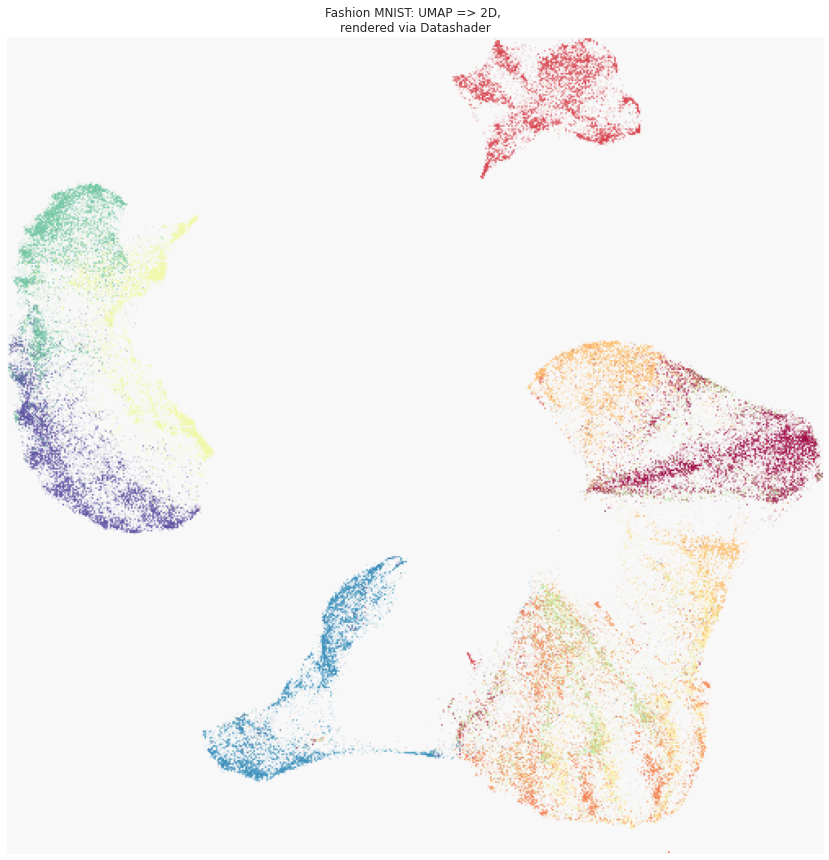

CPU times: user 1.14 s, sys: 29 ms, total: 1.17 s
Wall time: 1.2 s


In [9]:
%%time

# Plot via Datashader

df = pd.DataFrame(embedding, columns=('x', 'y'))
df['class'] = pd.Series([str(x) for x in target], dtype="category")

cvs = ds.Canvas(plot_width=500, plot_height=500)
agg = cvs.points(df, 'x', 'y', ds.count_cat('class'))
img = tf.shade(agg, color_key=color_key, how='eq_hist')

# JFT testing for bg color
#img = tf.set_background(img, '#c0c0c0')

ligth_gray = '#f8f8f8'

utils.export_image(img, filename='fashion-mnist', background='#f8f8f8')

image = plt.imread('fashion-mnist.png')
fig, ax = plt.subplots(figsize=(15, 15))

for spine in ax.spines.values():
  spine.set_edgecolor(ligth_gray)

plt.imshow(image)
plt.setp(ax, xticks=[], yticks=[])
plt.title("Fashion MNIST: UMAP => 2D, \n"
          "rendered via Datashader",
          fontsize=12)

plt.show()

The above plot may well be very sparse if
```python
config['use_small_dataset'] = False
```
`use_small_dataset` is set in the first code cell of this notebook.


In [0]:
import numpy as np
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

# Call once to configure Bokeh to display plots inline in the notebook.
output_notebook()


## Next and Future

Work from this notebook was forked and continued in [allen_institute_mouse_brain_cell_diversity.ipynb](https://colab.research.google.com/drive/1JO6PzzAI-MQqI9Q3FhkI8v6BA_tyhZ9I#scrollTo=WwNP4bmp6dgj).

### Bokeh and Datashader

Bokeh has a server (`bokeh serve` on the CLI) which would be great to have working with Datashader running on a Colab VM (See [Issue #61](https://github.com/reconstrue/single_cell_on_colab/issues/61)).

In [11]:
N = 4000
x = np.random.random(size=N) * 100
y = np.random.random(size=N) * 100
radii = np.random.random(size=N) * 1.5
colors = ["#%02x%02x%02x" % (r, g, 150) for r, g in zip(np.floor(50+2*x).astype(int), np.floor(30+2*y).astype(int))]

p = figure()
p.circle(x, y, radius=radii, fill_color=colors, fill_alpha=0.6, line_color=None)
show(p)

### WIP: UMAP pre-packaged datashader

[**Work in progress:** `!pip install umap-learn[plot]` fails with `ERROR:` about incompatible versions. So, just sticking with manually using Datashade as per above.]

The above technique manually uses datashader (e.g. [Datashader plotting Fashion MNIST](https://umap-learn.readthedocs.io/en/latest/auto_examples/plot_fashion-mnist_example.html)).

New as of 2020-03, `umap.plot` is part of `umap-learn` 0.4, and it will auto-sense when there are enough data points such that Datashader should be used for plotting:
```
import umap.plot
```
That eliminates overplotting etc. The docs are: [Plotting UMAP results](https://umap-learn.readthedocs.io/en/latest/plotting.html)

In [12]:
# Confirm that installed UMAP is v 0.4.x
!pip show umap-learn

Name: umap-learn
Version: 0.4.0
Summary: Uniform Manifold Approximation and Projection
Home-page: http://github.com/lmcinnes/umap
Author: None
Author-email: None
License: BSD
Location: /usr/local/lib/python3.6/dist-packages
Requires: numpy, tbb, scipy, numba, scikit-learn
Required-by: lucid


In [1]:
!pip install umap-learn[plot]

     |████████████████████████████████| 4.2MB 7.7MB/s 
     |████████████████████████████████| 1.6MB 52.6MB/s 
     |████████████████████████████████| 15.5MB 210kB/s 
     |████████████████████████████████| 71kB 11.4MB/s 
     |████████████████████████████████| 1.3MB 51.5MB/s 
     |████████████████████████████████| 81kB 12.8MB/s 
     |████████████████████████████████| 614kB 48.8MB/s 
  Created wheel for datashape: filename=datashape-0.5.2-cp36-none-any.whl size=59429 sha256=ad0870c0f3cedf5748cb5469670c75dc28f66f06d1d3774441a421b7decc7df6
  Stored in directory: /root/.cache/pip/wheels/8d/06/05/c1cba3d57bdcfd3960e3f60a9fdc97e4baef2ef09af0ad1ef8
  Created wheel for locket: filename=locket-0.2.0-cp36-none-any.whl size=4040 sha256=a2e29ff104f0f9dc270ddd35e72186bbfbd713de9022d6effc486adc9d19ef32
  Stored in directory: /root/.cache/pip/wheels/26/1e/e8/4fa236ec931b1a0cdd61578e20d4934d7bf188858723b84698
Successfully built datashape locket
ERROR: distributed 2.14.0 has requirement tornado>=5; 

In [0]:
# Result: no error but no gain
#
# !wget https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
# !chmod +x Miniconda3-4.5.4-Linux-x86_64.sh
# !bash ./Miniconda3-4.5.4-Linux-x86_64.sh -b -f -p /usr/local
# !conda install datashader bokeh holoviews colorcet
# import sys
# sys.path.append('/usr/local/lib/python3.6/site-packages/')


In [0]:
# import sys
# sys.path.append('/usr/local/lib/python3.6/site-packages/')


In [2]:
import umap.plot

# Docs say FMNIST is big enough to trigger Datashader
umap.plotl.points(embedding)


/usr/local/lib/python3.6/dist-packages/umap/plot.py:29: UserWarning: The umap.plot package requires extra plotting libraries to be installed.
    You can install these via pip using

    pip install umap-learn[plot]

    or via conda using

    conda install datashader bokeh holoviews colorcet
    
  """


ImportError: ignored

### cuDatashader

https://colab.research.google.com/drive/1bFIBg54zS9RmU58VwjJMAaqJ1xP27BXj
